In [1]:
#analyze dipole statistics over trials
import scipy
import mne
import os
from prediction_utils import *
import pandas as pd
responses = ['n15','p30','n45','p60']
response_lists = []
sites = ['Tuebingen','Aalto']
source_path_base =r"D:\REFTEP_ALL\Source_analysis"
gof_thresh_average = 75

In [2]:
#analyze single trial stability
usedsubs = []
df = pd.read_excel(r"D:\REFTEP_ALL\Source_analysis\Peak_times_all_n15_p30_n45_p60.xlsx")
response_data = {r:{} for r in responses + ['mep']}
ave_response_data = {r:{} for r in responses + ['mep']}
for response_ind, response in enumerate(responses + ['mep']):
    if response != "mep":
        all_amplitudes = []
        good_subjects_this_response = []
        amplitudes_all = []
        amplitudes_all_stds = []
        amplitudes_all_ptps = []
        amplitudes_all_ptps_stds = []
        gofs_all = []
        gofs_all_stds = []
        oris_all = []
        oris_all_stds = []
        amplitudes_all_ave = []
        gofs_all_ave = []
        oris_all_ave = []
        positions_all_ave = []
        times_all = []
        times_all_stds = []
        times_all_ave = []
        ptps_all_ave = []
        n_times_all_ave = []
        times_all_ave_pot = []
        picked_times = []
        idx = 0
        for site in sites:
            source_path_site = os.path.join(source_path_base,f'Source_analysis_{site}')
            subjects_dir = fr"D:\REFTEP_ALL\REFTEP_reco\{site}_recon_all/"
            for subject in os.listdir(source_path_site):
                subject_df = df[df['subject_id']==subject[4:]]
                gofs, gof_average, amplitudes, amplitude_average, oris, ori_average, times, time_average, pos, dipole_name, all_dipoles, dipole_average = load_dipole_stats_subject(source_path_site, subject, response)
                #only use data from these subjects in this response
                if gof_average >= gof_thresh_average:
                    trans = mne.read_trans(os.path.join(source_path_site,f'{subject}\{subject}_coreg\{subject}-trans.fif'),verbose=False)
                    forward = mne.read_forward_solution(os.path.join(source_path_site,f'{subject}\{subject}-fwd.fif'),verbose=False)
                    leadfield = forward['sol']['data'] - np.mean(forward['sol']['data'],axis=0) #average reference the leadfield
                    start_of_triplet_ind = int(dipole_name.split("_")[-1])*3
                    #epochs = mne.read_epochs(os.path.join(source_path_site,f'{subject}\{subject}_final_eeg-epo.fif')).get_data()
                    #n_trials = epochs.shape[0]
                    leadfield_source = leadfield[:,start_of_triplet_ind:start_of_triplet_ind+3]
                    fitting_times = np.load(os.path.join(source_path_site,f'{subject}\{subject}_dipoles\{subject}_dipole_{response}_fitting_times.npy'))
                    #print(response,fitting_times, time_average,subject)
                    n_times = len(fitting_times)
                    good_subjects_this_response.append(idx)
                    all_amplitudes.append(amplitudes)
                    amplitudes_all.append(np.mean(amplitudes))
                    amplitudes_all_stds.append(np.std(amplitudes))

                    mean_ori = np.mean(oris,axis=0) #mean orientation across all trials
                    diff_angles = []
                    ptps = []
                    for ori, amplitude in zip(oris,amplitudes): #calculate the difference in orientation (angles) between mean ori and all orientations
                        dotprod = np.dot(ori,mean_ori)
                        magnitude_ori = np.linalg.norm(ori)
                        magnitude_mean_ori = np.linalg.norm(mean_ori)
                        angle = np.degrees(np.arccos(np.clip(dotprod/(magnitude_ori*magnitude_mean_ori),-1.0,1.0)))
                        diff_angles.append(angle)
                        stc_now = ori * amplitude
                        dipole_in_sensor = np.matmul(leadfield_source,stc_now)
                        ptp = (np.max(dipole_in_sensor)-np.min(dipole_in_sensor))
                        ptps.append(ptp)

                    """epochs = mne.read_epochs(os.path.join(source_path_site,f'{subject}',f'{subject}_final_eeg-epo.fif'),verbose=False)
                    epochs_data = epochs.get_data(copy=True) #load the epochs data into a separate structure
                    n_trials = epochs_data.shape[0] #number of trials
                    for trial in range(n_trials):
                        evoked_trial = mne.EvokedArray(data=epochs_data[trial,:,:], info=epochs.info, tmin=epochs.times[0],nave=1, kind='single_epoch',verbose=False)
                        evoked_trial.plot_joint(title=f'{response}_{ptps[trial]*1e6}_{amplitudes[trial]*1e9}')"""

                    amplitudes_all_ptps.append(np.mean(ptps))
                    amplitudes_all_ptps_stds.append(np.std(ptps))

                    gofs_all.append(np.mean(gofs))
                    gofs_all_stds.append(np.std(gofs))

                    times_all.append(np.mean(times))
                    times_all_stds.append(np.std(times))

                    oris_all.append(np.mean(diff_angles))
                    oris_all_stds.append(np.std(diff_angles))

                    picked_times.append(subject_df[response].iloc[0])

                    #forward model the dipole back to sensor space
                    stc_now = ori_average * amplitude_average
                    dipole_in_sensor = np.matmul(leadfield_source,stc_now)
                    ptp = (np.max(dipole_in_sensor)-np.min(dipole_in_sensor))
                    ptps_all_ave.append(ptp)
                    
                    n_times_all_ave.append(n_times)
                    times_all_ave_pot.append(fitting_times)
                    #print("ptp",ptp)

                    #save info on fitting to the average response
                    amplitudes_all_ave.append(amplitude_average)
                    gofs_all_ave.append(gof_average)
                    oris_all_ave.append(ori_average)
                    pos_in_mni = mne.head_to_mni(pos, subject[0:7] + "_reco", trans, subjects_dir=subjects_dir)
                    positions_all_ave.append(pos_in_mni)
                    times_all_ave.append(time_average)
                    usedsubs.append(subject)
                    #mne.viz.plot_dipole_locations(dipole_average,trans=trans,subject=subject[0:7] + "_reco", subjects_dir=subjects_dir)
                    #mne.viz.plot_dipole_locations(all_dipoles[0],trans=trans,subject=subject[0:7] + "_reco", subjects_dir=subjects_dir)
                        #also load emg responses
    if response != "mep":
        n_subs = len(good_subjects_this_response)
        sqrt_n_subs = np.sqrt(n_subs)
        print(response, n_subs)

        response_data[response]['EV mean ($\%$)'] = str(round(np.mean(gofs_all),1)) + ' ± ' + str(round(np.std(gofs_all),1))
        response_data[response]['EV STD ($\%$)'] = str(round(np.mean(gofs_all_stds),1)) + ' ± ' + str(round(np.std(gofs_all_stds),1))

        response_data[response]['Amplitude mean (nAm)'] = str(round(np.mean(amplitudes_all)*1e9,1)) + ' ± ' + str(round(np.std(amplitudes_all)*1e9,1))
        response_data[response]['Amplitude STD (nAm)'] = str(round(np.mean(amplitudes_all_stds)*1e9,1)) + ' ± ' + str(round(np.std(amplitudes_all_stds)*1e9,1))

        response_data[response]['Peak-to-peak mean ($\mu$V)'] = str(round(np.mean(amplitudes_all_ptps)*1e6,1)) + ' ± ' + str(round(np.std(amplitudes_all_ptps)*1e6,1))
        response_data[response]['Peak-to-peak STD ($\mu$V)'] = str(round(np.mean(amplitudes_all_ptps_stds)*1e6,1)) + ' ± ' + str(round(np.std(amplitudes_all_ptps_stds)*1e6,1))

        response_data[response]['Latency mean (ms)'] = str(round(np.mean(times_all)*1e3,1)) + ' ± ' + str(round(np.std(times_all)*1e3,1))
        response_data[response]['Latency STD (ms)'] = str(round(np.mean(times_all_stds)*1e3,1)) + ' ± ' + str(round(np.std(times_all_stds)*1e3,1))

        response_data[response]['$\Delta$Angle (degrees)'] = str(round(np.mean(oris_all),1)) + ' ± ' + str(round(np.std(oris_all),1))



        print(f'gofs',round(np.mean(gofs_all),1), '±',round(np.std(gofs_all),1))
        print('amplitudes',round(np.mean(amplitudes_all)*1e9,1),'±', round(np.std(amplitudes_all)*1e9,1))
        print('amplitudes ptps',round(np.mean(amplitudes_all_ptps)*1e6,1),'±', round(np.std(amplitudes_all_ptps)*1e6,1))
        print('diff from mean ori',round(np.mean(oris_all),1),'±', round(np.std(oris_all),1))
        print('times',round(np.mean(times_all)*1e3,1),'±', round(np.std(times_all)*1e3,1))

        print('stds gofs',round(np.mean(gofs_all_stds),1),'±', round(np.std(gofs_all_stds),1))
        print('stds amplitudes',round(np.mean(amplitudes_all_stds)*1e9,1),'±', round(np.std(amplitudes_all_stds)*1e9,1))
        print('amplitudes ptps sds',round(np.mean(amplitudes_all_ptps_stds)*1e6,1),'±', round(np.std(amplitudes_all_ptps_stds)*1e6,1))
        print('stds oris',round(np.mean(oris_all_stds),1),'±', round(np.std(oris_all_stds),1))
        print('stds times',round(np.mean(times_all_stds)*1e3,1),'±', round(np.std(times_all_stds)*1e3,1))

        ave_response_data[response]['EV ($\%$)'] = str(round(np.mean(gofs_all_ave),1)) + ' ± ' + str(round(np.std(gofs_all_ave),1))
        ave_response_data[response]['Amplitude (nAm)'] = str(round(np.mean(amplitudes_all_ave)*1e9,1)) + ' ± ' + str(round(np.std(amplitudes_all_ave)*1e9,1))
        ave_response_data[response]['Peak-to-peak ($\mu$V)'] = str(round(np.mean(ptps_all_ave)*1e6,1)) + ' ± ' + str(round(np.std(ptps_all_ave)*1e6,1))
        ave_response_data[response]['Latency (ms)'] = str(round(np.mean(times_all_ave)*1e3,1)) + ' ± ' + str(round(np.std(times_all_ave)*1e3,1))
        ave_response_data[response]['Initial latency (ms)'] = str(round(np.mean(picked_times),1)) + ' ± ' + str(round(np.std(picked_times),1))
        ave_response_data[response]['Window size (ms)'] = str(round(np.mean(n_times_all_ave),1)) + ' ± ' + str(round(np.std(n_times_all_ave),1))
        times_all_ave_pot_ravel = [time for sublist in times_all_ave_pot for time in sublist]
        ave_response_data[response]['Max window limits (ms)'] = str(round(np.min(times_all_ave_pot_ravel)*1e3,1)) + '--' + str(round(np.max(times_all_ave_pot_ravel)*1e3,1))
        for ind, dim in enumerate(['x','y','z']):
            ave_response_data[response][f'loc {dim}'] = str(round(np.mean(positions_all_ave,axis=0)[ind],1)) + ' ± ' + str(round(np.std(positions_all_ave,axis=0)[ind],1))
        for ind, dim in enumerate(['x','y','z']):
            ave_response_data[response][f'ori {dim}'] = str(round(np.mean(oris_all_ave,axis=0)[ind]*100,1)) + ' ± ' + str(round(np.std(oris_all_ave,axis=0)[ind]*100,1))
    else:
        response_data[response]['EV mean ($\%$)'] = " - "
        response_data[response]['EV STD ($\%$)']  = " - "

        response_data[response]['Amplitude mean (nAm)'] = " - "
        response_data[response]['Amplitude STD (nAm)'] = " - "

        response_data[response]['Peak-to-peak mean ($\mu$V)'] = " - "
        response_data[response]['Peak-to-peak STD ($\mu$V)'] = " - "

        response_data[response]['Latency mean (ms)'] = " - "
        response_data[response]['Latency STD (ms)'] = " - "

        response_data[response]['$\Delta$Angle (degrees)'] = " - "

        ave_response_data[response]['EV ($\%$)'] = " - "
        ave_response_data[response]['Amplitude (nAm)'] = " - "
        ave_response_data[response]['Peak-to-peak ($\mu$V)'] = " - "
        ave_response_data[response]['Latency (ms)'] = " - "
        ave_response_data[response]['Initial latency (ms)'] = " - "
        ave_response_data[response]['Window size (ms)'] = " - "
        ave_response_data[response]['Max window limits (ms)'] = " - "
        for ind, dim in enumerate(['x','y','z']):
            ave_response_data[response][f'loc {dim}'] = " - "
        for ind, dim in enumerate(['x','y','z']):
            ave_response_data[response][f'ori {dim}'] = " - "
    


n15 24
gofs 61.4 ± 8.0
amplitudes 62.0 ± 30.4
amplitudes ptps 12.0 ± 6.2
diff from mean ori 55.9 ± 14.2
times 18.8 ± 3.5
stds gofs 18.3 ± 1.8
stds amplitudes 30.9 ± 20.6
amplitudes ptps sds 5.8 ± 4.7
stds oris 35.4 ± 7.4
stds times 2.0 ± 0.9
p30 37
gofs 69.3 ± 8.1
amplitudes 64.4 ± 40.5
amplitudes ptps 12.4 ± 4.9
diff from mean ori 54.9 ± 12.9
times 33.4 ± 4.3
stds gofs 16.6 ± 2.4
stds amplitudes 28.2 ± 17.5
amplitudes ptps sds 5.4 ± 2.1
stds oris 34.1 ± 6.2
stds times 1.8 ± 0.7
n45 52
gofs 78.5 ± 7.2
amplitudes 89.4 ± 36.4
amplitudes ptps 16.0 ± 5.4
diff from mean ori 49.0 ± 12.8
times 46.0 ± 4.1
stds gofs 13.5 ± 3.2
stds amplitudes 37.5 ± 17.4
amplitudes ptps sds 6.3 ± 2.1
stds oris 32.2 ± 9.3
stds times 2.6 ± 0.8
p60 51
gofs 80.2 ± 8.9
amplitudes 92.5 ± 34.8
amplitudes ptps 16.9 ± 5.7
diff from mean ori 47.0 ± 15.4
times 60.3 ± 5.2
stds gofs 12.3 ± 3.4
stds amplitudes 36.6 ± 16.3
amplitudes ptps sds 6.5 ± 2.0
stds oris 29.8 ± 9.5
stds times 2.9 ± 0.9


In [3]:
#print out latex tables
df = pd.DataFrame(ave_response_data)
print(df.to_latex())
df2 = pd.DataFrame(response_data)
print(df2.to_latex())

\begin{tabular}{llllll}
\toprule
 & n15 & p30 & n45 & p60 & mep \\
\midrule
EV ($\%$) & 83.7 ± 5.9 & 89.1 ± 6.7 & 92.8 ± 5.0 & 94.0 ± 4.5 &  -  \\
Amplitude (nAm) & 30.9 ± 19.8 & 36.7 ± 38.7 & 53.3 ± 32.1 & 58.1 ± 35.9 &  -  \\
Peak-to-peak ($\mu$V) & 6.0 ± 4.0 & 6.6 ± 4.2 & 9.5 ± 5.3 & 10.5 ± 6.3 &  -  \\
Latency (ms) & 19.5 ± 4.0 & 33.7 ± 4.4 & 46.0 ± 4.8 & 60.2 ± 5.9 &  -  \\
Initial latency (ms) & 17.6 ± 3.1 & 32.4 ± 3.9 & 45.0 ± 4.5 & 60.1 ± 5.1 &  -  \\
Window size (ms) & 5.9 ± 2.4 & 5.5 ± 2.2 & 7.7 ± 2.2 & 8.2 ± 2.5 &  -  \\
Max window limits (ms) & 11.0--30.0 & 22.0--42.0 & 34.0--59.0 & 48.0--78.0 &  -  \\
loc x & 5.4 ± 19.0 & 1.1 ± 18.2 & -3.1 ± 17.9 & -6.7 ± 18.8 &  -  \\
loc y & -30.4 ± 32.2 & -27.8 ± 26.3 & -27.3 ± 23.2 & -26.6 ± 21.4 &  -  \\
loc z & 30.7 ± 30.7 & 37.7 ± 15.8 & 25.3 ± 24.9 & 28.3 ± 18.9 &  -  \\
ori x & 2.2 ± 51.2 & -16.4 ± 48.7 & -39.9 ± 41.3 & -54.6 ± 29.3 &  -  \\
ori y & 8.6 ± 57.6 & -0.6 ± 57.5 & -31.0 ± 41.4 & -40.3 ± 32.6 &  -  \\
ori z & 15.0 ± 61.

In [4]:
#analyze tep-tep and tep-mep correlations across trials and trends in amplitudes
from pymannkendall import original_test
from collections import Counter
import scipy.io
all_responses = responses + ['mep']
amps = {r:[] for r in all_responses}
gofs_all = {r:[] for r in all_responses}
ori_diffs = {r:[] for r in all_responses}
good_subjects_this_response = {r:[] for r in all_responses}
latencies_all = []
coil_ori_diffs = []
coil_pos_diffs = []
coil_normal_diffs = []
coil_good_inds_notnans = []
good_subs_coil = []
for response_ind, response in enumerate(all_responses):
    all_amplitudes = []
    all_amps_means = []
    all_amps_stds = []
    idx = 0
    significants_amp = 0
    slopes_amp  = []
    trends_amp  = []
    significants_gof = 0
    slopes_gof = []
    trends_gof = []
    for site in sites:
        source_path_site = os.path.join(source_path_base,f'Source_analysis_{site}')
        for subject in os.listdir(source_path_site):
            #get stimulation latencies
            if response != 'mep':
                gofs, gof_average, amplitudes, amplitude_average, oris, ori_average, times, time_average, pos, dipole_name, all_dipoles, dipole_average = load_dipole_stats_subject(source_path_site, subject, response)
                #only use data from these subjects in this response
                gofs = np.array(gofs)
                mean_ori = np.mean(oris,axis=0) #mean orientation across all trials
                if gof_average >= gof_thresh_average:
                    good_subjects_this_response[response].append(idx)
                    amplitudes = np.array(amplitudes)*1e12
                    all_amplitudes.append(amplitudes)
                diff_angles = []
                for ori in oris: #calculate the difference in orientation (angles) between mean ori and all orientations
                    dotprod = np.dot(ori,mean_ori)
                    magnitude_ori = np.linalg.norm(ori)
                    magnitude_mean_ori = np.linalg.norm(mean_ori)
                    angle = np.degrees(np.arccos(np.clip(dotprod/(magnitude_ori*magnitude_mean_ori),-1.0,1.0)))
                    diff_angles.append(angle)
                ori_diffs[response].append(diff_angles)
            else:
                good_subjects_this_response[response].append(idx)
                amplitudes = np.load(os.path.join(source_path_site,subject,f'{subject}_mep_amplitudes.npy'))*1e6
                all_amplitudes.append(amplitudes)
                all_amps_means.append(np.mean(amplitudes))
                all_amps_stds.append(np.std(amplitudes))
            amps[response].append(amplitudes)
            if response=="mep":
                gofs = np.array([0]) #no gofs for meps
            gofs_all[response].append(gofs)
            if gof_average >= gof_thresh_average or response == 'mep':
                mk_result_general_amp = original_test(amplitudes)
                if mk_result_general_amp.p < 0.05:
                    significants_amp  +=1
                    trends_amp.append(mk_result_general_amp.trend)
                    slopes_amp.append(mk_result_general_amp.slope)
                if response != "mep":
                    mk_result_general_gof = original_test(gofs)
                    if mk_result_general_gof.p < 0.05:
                        significants_gof +=1
                        trends_gof.append(mk_result_general_gof.trend)
                        slopes_gof.append(mk_result_general_gof.slope)
            idx += 1
    print(response, significants_amp, Counter(trends_amp), round(np.mean(np.abs(slopes_amp)),1), '±', round(np.std(np.abs(slopes_amp)),1),'amp')
    if response != "mep":
        print(response, significants_gof, Counter(trends_gof), round(np.mean(np.abs(slopes_gof))*1e3,1),'±',round(np.std(np.abs(slopes_gof))*1e3,1),'gof')
    if response == "mep":
        print('ave amps meps',round(np.mean(all_amps_means),1),'±', round(np.std(all_amps_means),1))
        print('std amps meps',round(np.mean(all_amps_stds),1),'±', round(np.std(all_amps_stds),1))



n15 11 Counter({'increasing': 7, 'decreasing': 4}) 9.0 ± 3.7 amp
n15 7 Counter({'decreasing': 5, 'increasing': 2}) 7.2 ± 2.6 gof
p30 16 Counter({'increasing': 8, 'decreasing': 8}) 9.3 ± 4.7 amp
p30 16 Counter({'increasing': 9, 'decreasing': 7}) 4.3 ± 1.5 gof
n45 26 Counter({'decreasing': 15, 'increasing': 11}) 12.9 ± 5.8 amp
n45 21 Counter({'increasing': 12, 'decreasing': 9}) 3.3 ± 1.5 gof
p60 26 Counter({'increasing': 15, 'decreasing': 11}) 13.7 ± 6.7 amp
p60 23 Counter({'increasing': 13, 'decreasing': 10}) 3.1 ± 1.5 gof
mep 41 Counter({'increasing': 33, 'decreasing': 8}) 0.7 ± 0.9 amp
ave amps meps 1123.3 ± 1012.8
std amps meps 908.8 ± 634.5


In [5]:
#perform correlation analysis on meps and teps
from scipy.stats import pearsonr
from scipy.stats import spearmanr
def get_corrs(arr1,arr2,type='pearsonr'):
    corrs = []
    for a1, a2 in zip(arr1, arr2):
        if type=='pearsonr':
            correlation, p_value = pearsonr(np.log(a1), np.log(a2))
        else:
            correlation, p_value = spearmanr(a1, a2)
        if p_value < 0.05:
            corrs.append(correlation)
    return corrs
#correlation arrays for values and the number of cases
correlations = {r:{} for r in all_responses}
corrnums = {r:{} for r in all_responses}
#go through all responses
for ind1, response1 in enumerate(all_responses):
    for response2 in all_responses[ind1+1:]: #what subjects are good in both cases
        both_good_subjects_indices = np.intersect1d(good_subjects_this_response[response1],good_subjects_this_response[response2]).astype(int)
        #read amplitudes and store the correlations
        amplitudes1 = []
        amplitudes2 = []
        for ind in both_good_subjects_indices:
            amplitudes1.append(amps[response1][ind])
            amplitudes2.append(amps[response2][ind])
        corrs = get_corrs(amplitudes1,amplitudes2) #TEP-TEP correlations for all subjects
        correlations[response1][response2] = np.mean(corrs) #mean across subjects
        corrnums[response1][response2] = len(corrs)/len(amplitudes1) #how many were significant
        print(response1, response2, np.mean(corrs), np.std(corrs), len(corrs))
    #read amplitudes and other dipole metrics and calculate correlations
    amps_now = []
    diff_oris_now = []
    gofs_now = []
    for index_good in good_subjects_this_response[response1]:
        amps_now.append(amps[response1][index_good])
        if response1!="mep":
            diff_oris_now.append(ori_diffs[response1][index_good])
            gofs_now.append(gofs_all[response1][index_good])
    if response1 != "mep":
        corrs = get_corrs(amps_now,diff_oris_now) #correlations between amplitudes and ori diffs
        print(response1, 'oridiff', np.mean(corrs), np.std(corrs), len(corrs))
        correlations[response1]['diff_ori_dipole'] = np.mean(corrs)
        corrnums[response1]['diff_ori_dipole']=len(corrs)/len(amps_now)
        cori = get_corrs(gofs_now,diff_oris_now) #gof-ori correlations
        camps = get_corrs(gofs_now,amps_now) #gof-amp correlations
        print(response1,'gofs and oris',round(np.mean(cori),2), len(cori)/len(gofs_now), round(np.std(cori),2), np.min(cori), np.max(cori))
        print(response1,'gofs and amps',round(np.mean(camps),2), len(camps)/len(gofs_now), round(np.std(camps),2), np.min(camps), np.max(camps))
    else: #no dipoles for MEPs
        correlations[response1]['diff_ori_dipole'] = 0
        corrnums[response1]['diff_ori_dipole'] = 0
    print("\n")
    

n15 p30 0.3672967477273249 0.25513500240328707 19
n15 n45 0.11892834207640375 0.08169671770960732 15
n15 p60 0.11390580763403253 0.0445095524242059 18
n15 mep 0.15621731583001738 0.10757955939977404 9
n15 oridiff -0.2549791712636178 0.15479079162177475 16
n15 gofs and oris -0.28 0.9583333333333334 0.11 -0.4552153867052074 -0.13203997095232656
n15 gofs and amps 0.64 1.0 0.08 0.4308796150991546 0.776157403598358


p30 n45 0.36959470101772934 0.19214577448108758 33
p30 p60 0.19867140501077196 0.08457340022056908 31
p30 mep 0.07834343968610247 0.10738042424933672 18
p30 oridiff -0.19975567799387725 0.1104577208493015 32
p30 gofs and oris -0.29 1.0 0.11 -0.5341937784503207 -0.10207180627306904
p30 gofs and amps 0.61 1.0 0.08 0.45240610152903804 0.770363394283363


n45 p60 0.4707269790675786 0.15742735230905794 49
n45 mep 0.06633825371212321 0.14735723081467977 17
n45 oridiff -0.20364089812103744 0.149270075141277 41
n45 gofs and oris -0.31 1.0 0.11 -0.5244469052667355 -0.11292958970196769
n

In [6]:
print(correlations)

{'n15': {'p30': 0.3672967477273249, 'n45': 0.11892834207640375, 'p60': 0.11390580763403253, 'mep': 0.15621731583001738, 'diff_ori_dipole': -0.2549791712636178}, 'p30': {'n45': 0.36959470101772934, 'p60': 0.19867140501077196, 'mep': 0.07834343968610247, 'diff_ori_dipole': -0.19975567799387725}, 'n45': {'p60': 0.4707269790675786, 'mep': 0.06633825371212321, 'diff_ori_dipole': -0.20364089812103744}, 'p60': {'mep': 0.08677461999294894, 'diff_ori_dipole': -0.17514394398353833}, 'mep': {'diff_ori_dipole': 0}}


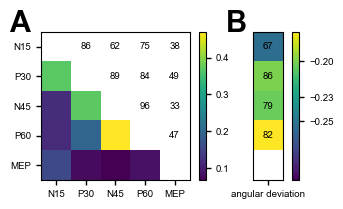

In [7]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['pdf.fonttype']=42
#define matrices with correlation coefficients by reading labels from the correlation dictionary
matrix=np.zeros(shape=(5,5))
matrix_numbers = np.zeros(shape=(5,5))
for ind1, response1 in enumerate(all_responses):
    for response2 in all_responses[ind1+1:]:
        ind2 = all_responses.index(response2)
        matrix[ind1,ind2] =  correlations[response1][response2]
        matrix_numbers[ind1,ind2] = corrnums[response1][response2]

diff_ori_corrs = np.array([correlations[response]['diff_ori_dipole'] for response in all_responses])
diff_ori_corrs_numbers = np.array([corrnums[response]['diff_ori_dipole'] for response in all_responses])
vmin = np.min(np.array([np.min(matrix),np.min(diff_ori_corrs)]))
vmax = np.max(np.array([np.max(matrix),np.max(diff_ori_corrs)]))
diff_ori_corrs_numbers[diff_ori_corrs_numbers==0] = np.nan
diff_ori_corrs_copy = diff_ori_corrs.copy()
diff_ori_corrs[diff_ori_corrs==0] = np.nan
matrix_copy = matrix.copy()
matrix[matrix==0] = np.nan
matrix_numbers[matrix_numbers==0] = np.nan
matrix = np.transpose(matrix)
in_mm_scale = 25.4


fig, axs = plt.subplots(1,2, figsize=(91.5/in_mm_scale,49/in_mm_scale))
image = axs[0].imshow(matrix,cmap='viridis')
all_responses_upper = [response.upper() for response in all_responses] #names in upper
#set ticks for the images
axs[0].set_xticks(np.arange(5))
axs[0].set_yticks(np.arange(5))
axs[0].set_yticklabels(all_responses_upper,fontsize=7)
axs[0].set_xticklabels(all_responses_upper,fontsize=7)
axs[1].set_xticks(np.arange(1))

for i in range(len(matrix_numbers)):
    for j in range(len(matrix_numbers)):
        if str(matrix_numbers[i,j]) != "nan":
            axs[0].text(j,i,f'{round(100*(matrix_numbers[i,j]))}',ha='center',va='center',color='black',fontsize=7)
diff_ori_corrs = diff_ori_corrs.reshape(5,1)
axs[1].tick_params(width=1)
axs[0].tick_params(width=1)
image2 = axs[1].imshow(diff_ori_corrs,cmap='viridis',vmin=-0.3)
axs[1].set_xticklabels(["angular deviation"],fontsize=7)
for i in range(len(diff_ori_corrs_numbers)):
    if str(diff_ori_corrs_numbers[i]) != "nan":
        axs[1].text(0,i,f'{round(100*(diff_ori_corrs_numbers[i]))}',ha='center',va='center',color='black',fontsize=7)
cbar = plt.colorbar(image, ticks=np.round(np.linspace(np.min(matrix_copy),np.max(matrix_copy),6),1))
cbar.ax.tick_params(labelsize=7)
pos = cbar.ax.get_position()
cbar.ax.tick_params(width=1)
cbar = plt.colorbar(image2, ticks=np.round(np.linspace(np.min(diff_ori_corrs_copy),np.max(diff_ori_corrs_copy),10),2))
cbar.ax.tick_params(labelsize=7)
pos = cbar.ax.get_position()
cbar.ax.tick_params(width=1)
plt.subplots_adjust(wspace=-0.5)
fig.text(0.04, 0.88, 'A',fontsize=21,fontweight='bold')
fig.text(0.64, 0.88, 'B',fontsize=21,fontweight='bold')
axs[1].set_yticks([])
plt.savefig('correlation_plot_responses_59.pdf',format='pdf',dpi=300)